# 895 Practical Machine Learning and Applications - Project 2
# Joseph Martínez Salcedo - 01236703

## Downloading data and installing libraries

In [ ]:
# !kaggle competitions download -c hms-harmful-brain-activity-classification
# !unzip hms-harmful-brain-activity-classification.zip data/

In [ ]:
# !pip install -q keras_cv==0.8.2
# !pip install -q tensorflow==2.15.0
# !pip install -q keras==3.0.4

In [29]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt 

In [30]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.15.0
Keras: 3.0.4
KerasCV: 0.8.2


## Model configuration

In [31]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
#   preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    preset = "mobilenet_v3_large_imagenet"  # Name of pretrained classifier
    image_size = [400, 300]  # Input image size
    epochs = 13 # Training epochs
    batch_size = 64  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}

# Reproductibility:
keras.utils.set_random_seed(CFG.seed)

## Loading data

In [32]:
BASE_PATH = "data"

SPEC_DIR = "/tmp/dataset/hms-hbac"
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)

In [33]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{SPEC_DIR}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(CFG.name2label)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{SPEC_DIR}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0


,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec2_path
0,853520,3911565283,6885,data/test_eegs/3911565283.parquet,data/test_spectrograms/853520.parquet,/tmp/dataset/hms-hbac/test_spectrograms/853520...


In [ ]:
# Define a function to process a single eeg_id
def process_spec(spec_id, split="train"):
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()

# Parallelize the processing using joblib for training data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids, total=len(spec_ids))
)

# Get unique spec_ids of test data
test_spec_ids = test_df["spectrogram_id"].unique()

# Parallelize the processing using joblib for test data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "test")
    for spec_id in tqdm(test_spec_ids, total=len(test_spec_ids))
)

In [35]:
def build_augmenter(dim=CFG.image_size):
    augmenters = [
        keras_cv.layers.MixUp(alpha=2.0),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.1)), # freq-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # time-masking
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.5:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size, dtype=32):
    def decode_signal(path, offset=None):
        # Read .npy files and process the signal
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])
        
        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None: 
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]
            
            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])
        
        # Log spectrogram 
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)
        
        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6
        
        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig
    
    def decode_label(label):
        label = tf.one_hot(label, CFG.num_classes)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.num_classes])
        return label
    
    def decode_with_labels(path, offset=None, label=None):
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)
    
    return decode_with_labels if with_labels else decode_signal


def build_dataset(paths, offsets=None, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=False, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In [36]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

df["fold"] = -1
df.reset_index(drop=True, inplace=True)
for fold, (train_idx, valid_idx) in enumerate(
    sgkf.split(df, y=df["class_label"], groups=df["patient_id"])
):
    df.loc[valid_idx, "fold"] = fold
df.groupby(["fold", "class_name"])[["eeg_id"]].count().T

fold           0                                     1                    ...  \
class_name   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA  ...   
eeg_id      2050  2605  1168  3793  3462    4007  4832  4856  4463  3117  ...   

fold           3                         4                                  
class_name   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure  
eeg_id      2318  4296  3884    4787  1889  3700  4249  3002  4013    4045  

[1 rows x 30 columns]

In [37]:
# Sample from full data
sample_df = df.groupby("spectrogram_id").head(1).reset_index(drop=True)
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Train
train_paths = train_df.spec2_path.values
train_offsets = train_df.spectrogram_label_offset_seconds.values.astype(int)
train_labels = train_df.class_label.values
train_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=True)

# Valid
valid_paths = valid_df.spec2_path.values
valid_offsets = valid_df.spectrogram_label_offset_seconds.values.astype(int)
valid_labels = valid_df.class_label.values
valid_ds = build_dataset(valid_paths, valid_offsets, valid_labels, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=True)

# Num Train: 9166 | Num Valid: 1972


### Dataset Check

In [38]:
imgs, tars = next(iter(train_ds))

num_imgs = 8
plt.figure(figsize=(4*4, num_imgs//4*5))
for i in range(num_imgs):
    plt.subplot(num_imgs//4, 4, i + 1)
    img = imgs[i].numpy()[...,0]  # Adjust as per your image data format
    img -= img.min()
    img /= img.max() + 1e-4
    tar = CFG.label2name[np.argmax(tars[i].numpy())]
    plt.imshow(img)
    plt.title(f"Target: {tar}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

2024-04-21 16:30:42.169622: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [39]:
LOSS = keras.losses.KLDivergence()

## Model

In [ ]:
# Build Classifier
model = keras_cv.models.ImageClassifier.from_preset(
    CFG.preset, num_classes=CFG.num_classes
)

# Compile the model  
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS)

# Model Sumamry
model.summary()

### LR Schedule

In [41]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

In [42]:
lr_cb = get_lr_callback(CFG.batch_size, mode=CFG.lr_mode, plot=True)

In [43]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.keras",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min')

### Train model

In [ ]:
history = model.fit(
    train_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose
)

(The model was trained the the Kaggle Environment). Training results:
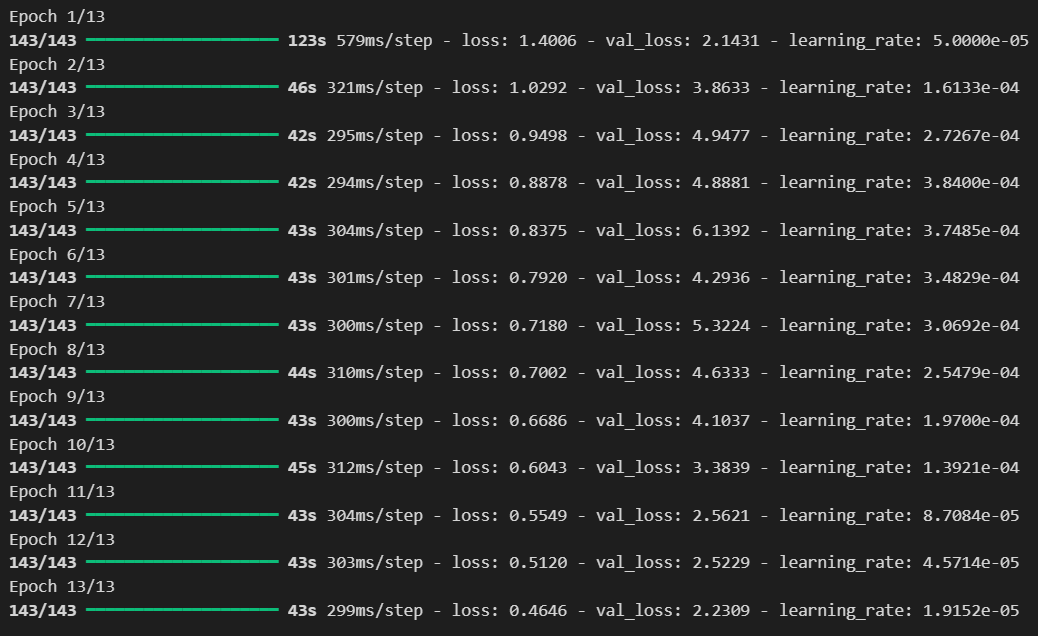

### Load best model and inference

In [ ]:
model.load_weights("best_model.keras")

In [ ]:
# Build Test Dataset
test_paths = test_df.spec2_path.values
test_ds = build_dataset(test_paths, batch_size=min(CFG.batch_size, len(test_df)),
                         repeat=False, shuffle=False, cache=False, augment=False)
# Inference
preds = model.predict(test_ds)

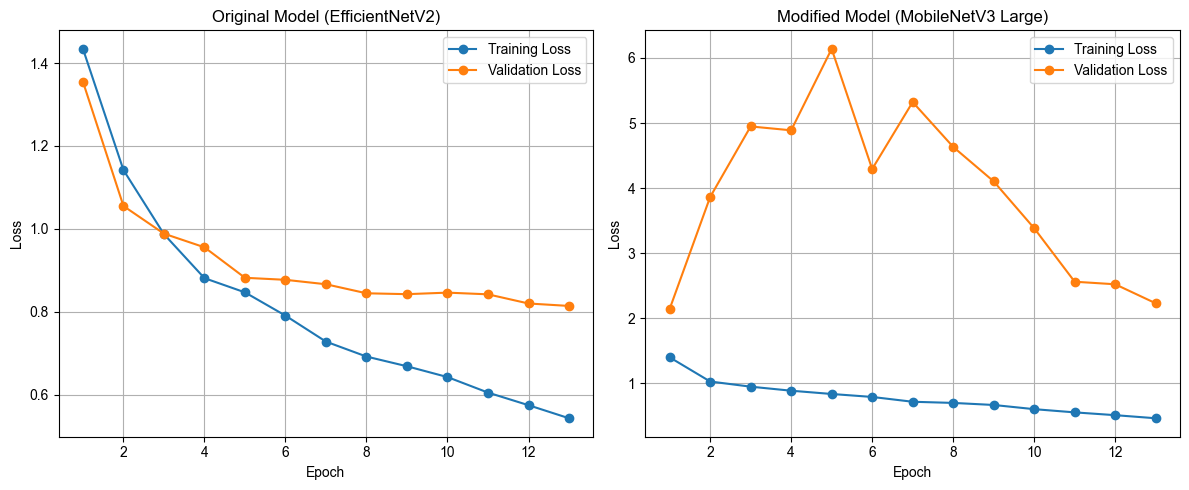

In [7]:
import matplotlib.pyplot as plt

# Setting font to Arial 10
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Data for original model
epochs_original = list(range(1, 14))
loss_original_train = [1.4342, 1.1419, 0.9873, 0.8812, 0.8469, 0.7908, 0.7281, 0.6921, 0.6687, 0.6426, 0.6052, 0.5748, 0.5433]
loss_original_val = [1.3549, 1.0552, 0.9885, 0.9556, 0.8821, 0.8772, 0.8665, 0.8447, 0.8426, 0.8463, 0.8422, 0.8201, 0.8142]

# Data for modified model
epochs_modified = list(range(1, 14))
loss_modified_train = [1.4006, 1.0292, 0.9498, 0.8878, 0.8375, 0.7920, 0.7180, 0.7002, 0.6686, 0.6043, 0.5549, 0.5120, 0.4646]
loss_modified_val = [2.1431, 3.8633, 4.9477, 4.8881, 6.1392, 4.2936, 5.3224, 4.6333, 4.1037, 3.3839, 2.5621, 2.5229, 2.2309]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1: Original Model
axs[0].plot(epochs_original, loss_original_train, marker='o', label='Training Loss')
axs[0].plot(epochs_original, loss_original_val, marker='o', label='Validation Loss')
axs[0].set_title('Original Model (EfficientNetV2)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Modified Model
axs[1].plot(epochs_modified, loss_modified_train, marker='o', label='Training Loss')
axs[1].plot(epochs_modified, loss_modified_val, marker='o', label='Validation Loss')
axs[1].set_title('Modified Model (MobileNetV3 Large)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("loss_vs_epoch_subplots.svg", format="svg")

# Display plot
plt.show()


#